# 01. Exploratory Data Analysis (EDA)

**Objective:** Understand the data structure, identify quality issues (missing values, outliers), and discover patterns to inform the modeling strategy.

**Methodology:** 
To strictly adhere to **Data Leakage** prevention principles, we will perform EDA **exclusively** on the Training set. The Validation set must remain unseen until the evaluation phase.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import sys
import os

# Add project root to path to allow importing from src
sys.path.append(os.path.abspath('..'))

from src.sml_homework.data_loader import load_and_split_data
from src.sml_homework.visualization import (
    plot_target_distribution,
    plot_numerical_distributions,
    plot_categorical_distributions,
    plot_correlation_heatmap,
    plot_boxplots
)

## 1. Load and Prepare Data for Analysis

We load the data and immediately split it. We then recombine the training features and target into a single DataFrame (`train_df`) to facilitate visualization.

In [2]:
# Load and split (Stratified to preserve class balance)
X_train, X_val, y_train, y_val = load_and_split_data('../data/raw/train.csv')

# Recombine X and y for EDA plotting purposes
train_df = X_train.copy()
train_df['loan_paid_back'] = y_train

print(f"Training Data Shape: {train_df.shape}")
print(f"Validation Data Shape: {X_val.shape} (Reserved)")

Training Data Shape: (475195, 13)
Validation Data Shape: (118799, 12) (Reserved)


## 2. Target Variable Analysis (Class Imbalance)

We check the distribution of `loan_paid_back`. A significant imbalance would justify the use of Stratified Splitting and potentially Resampling techniques (SMOTE) in the modeling phase.

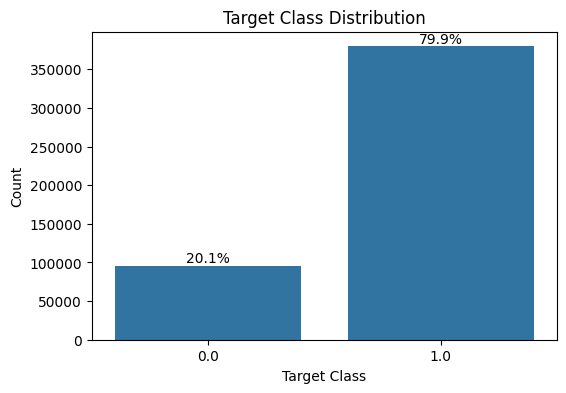

In [3]:
plot_target_distribution(train_df['loan_paid_back'])

## 3. Numerical Feature Analysis

We analyze continuous variables for skewness and outliers. 
* **Skewness:** Highly skewed features (like `annual_income`) might benefit from Log Transformation.
* **Distributions:** Understanding the shape helps in choosing scaling methods (StandardScaler vs MinMaxScaler).

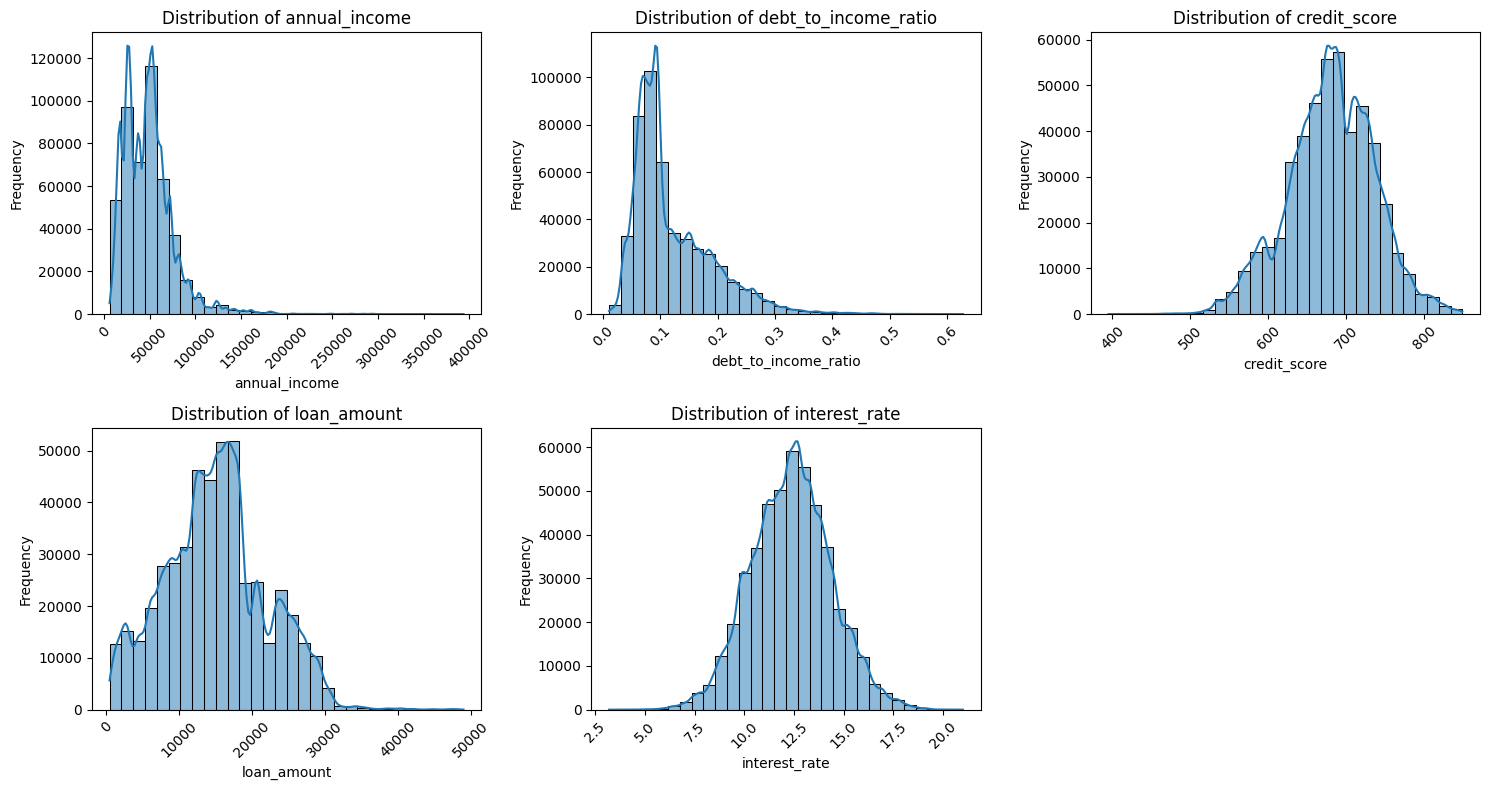

In [4]:
plot_numerical_distributions(train_df)

### Outlier Detection
Boxplots help us visualize the range and outliers. 
* If `annual_income` or `debt_to_income_ratio` show extreme values, we may need to cap them or use robust scalers.

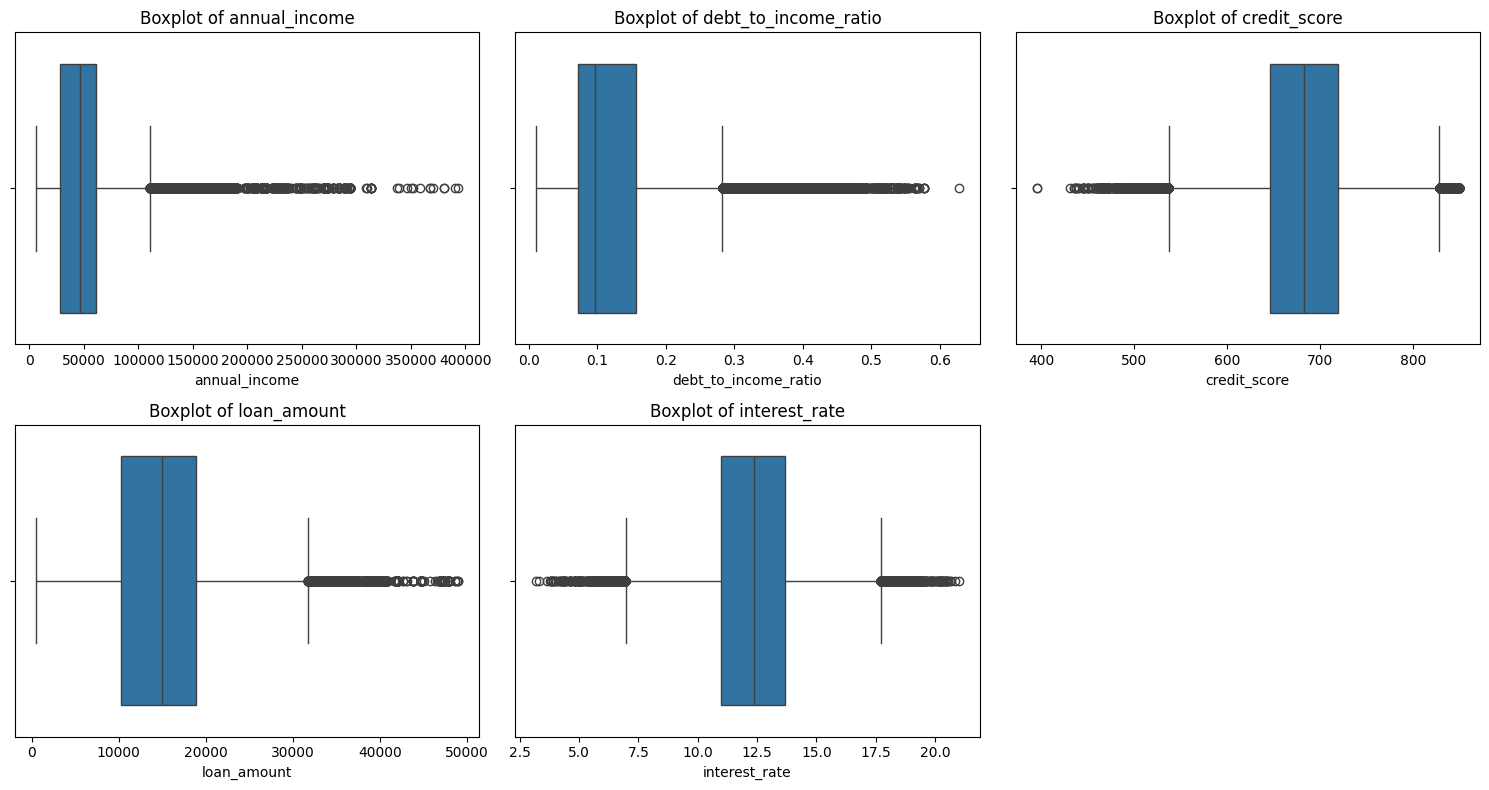

In [5]:
plot_boxplots(train_df)

## 4. Categorical Feature Analysis

We examine the cardinality (number of unique values) of categorical features.
* **High Cardinality:** Features with many categories (like `grade_subgrade` or `loan_purpose`) may require special encoding strategies (like Ordinal Encoding or grouping) to avoid the Curse of Dimensionality.

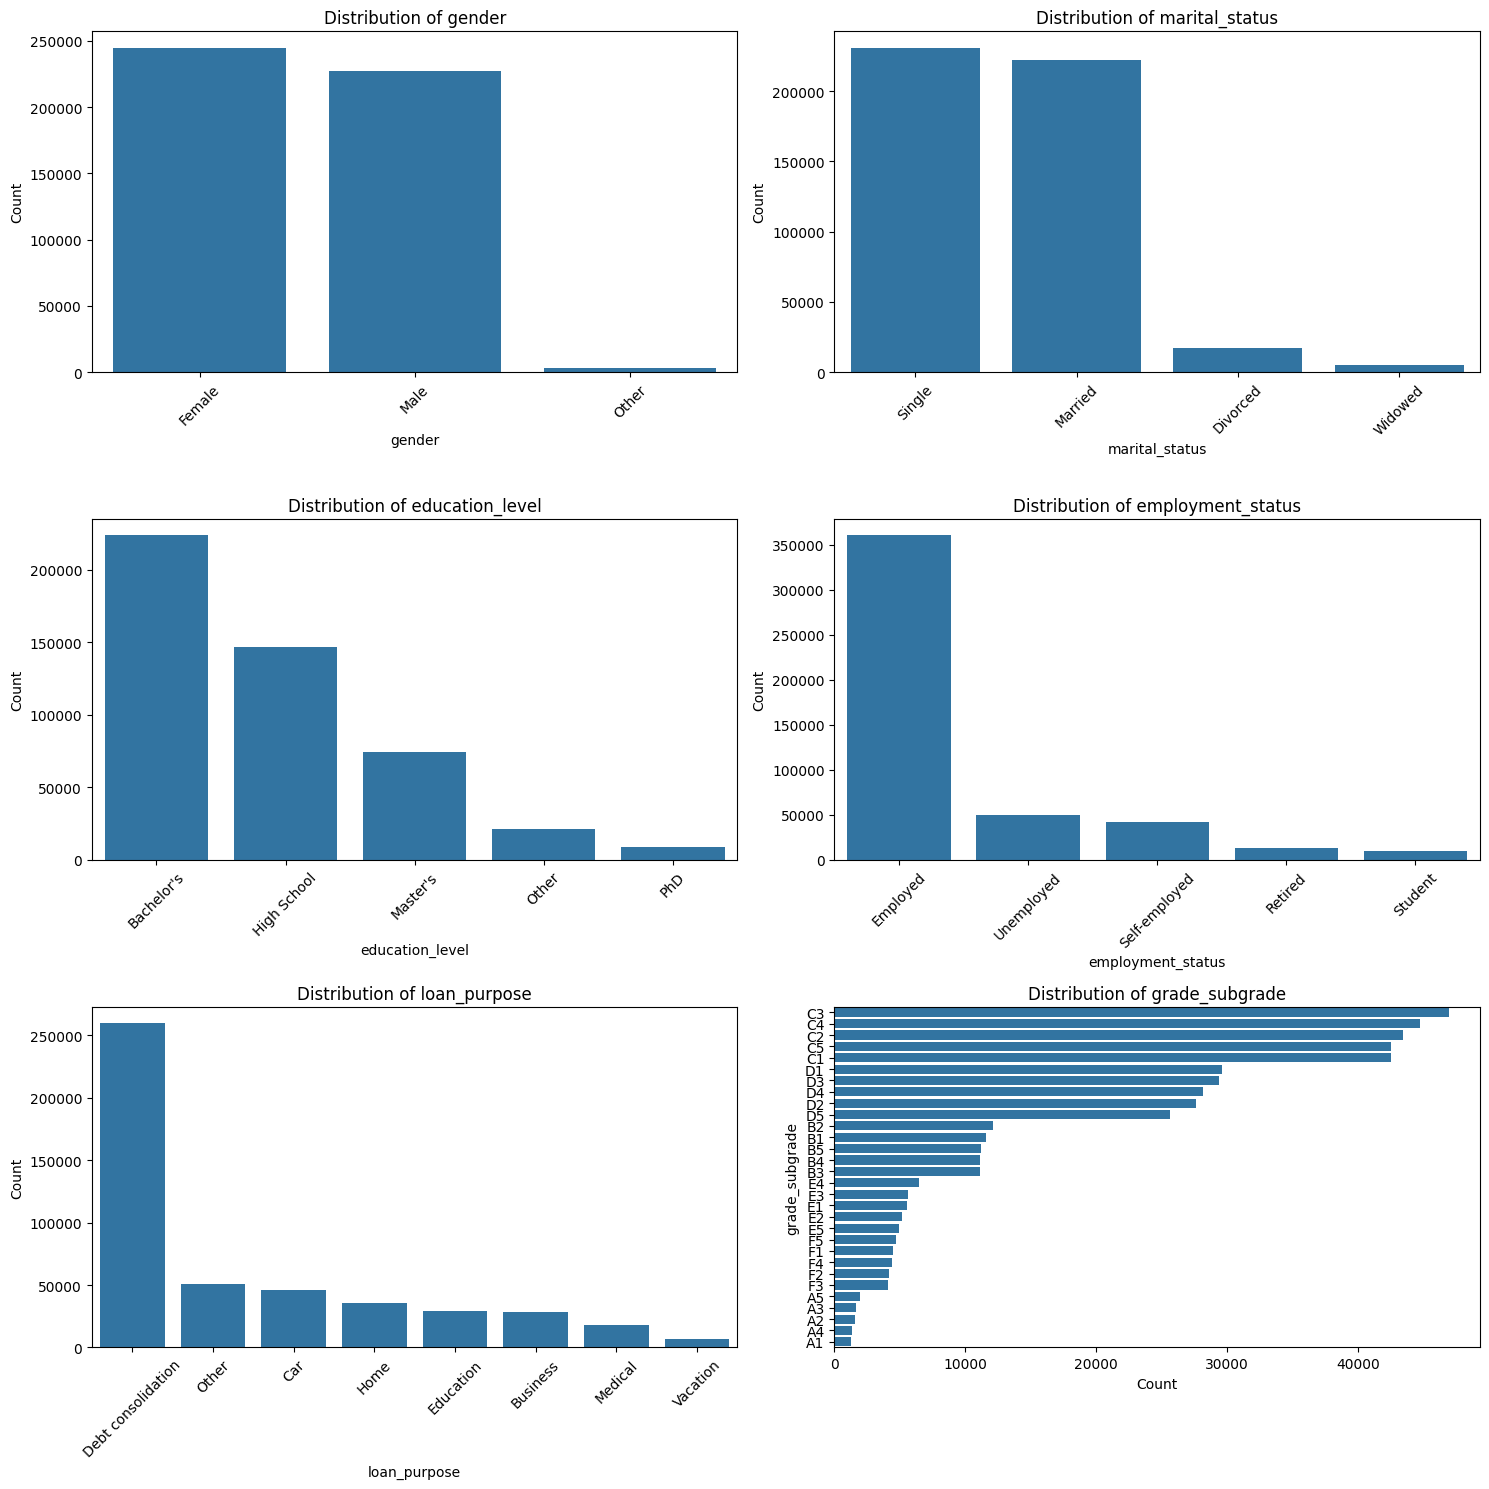

In [6]:
plot_categorical_distributions(train_df)

## 5. Correlation Analysis

We check for **Multicollinearity** (strong correlation between independent variables). 
* **Redundancy:** If two features are highly correlated (e.g., > 0.8), they provide redundant information, which can destabilize linear models. We may need to drop one.

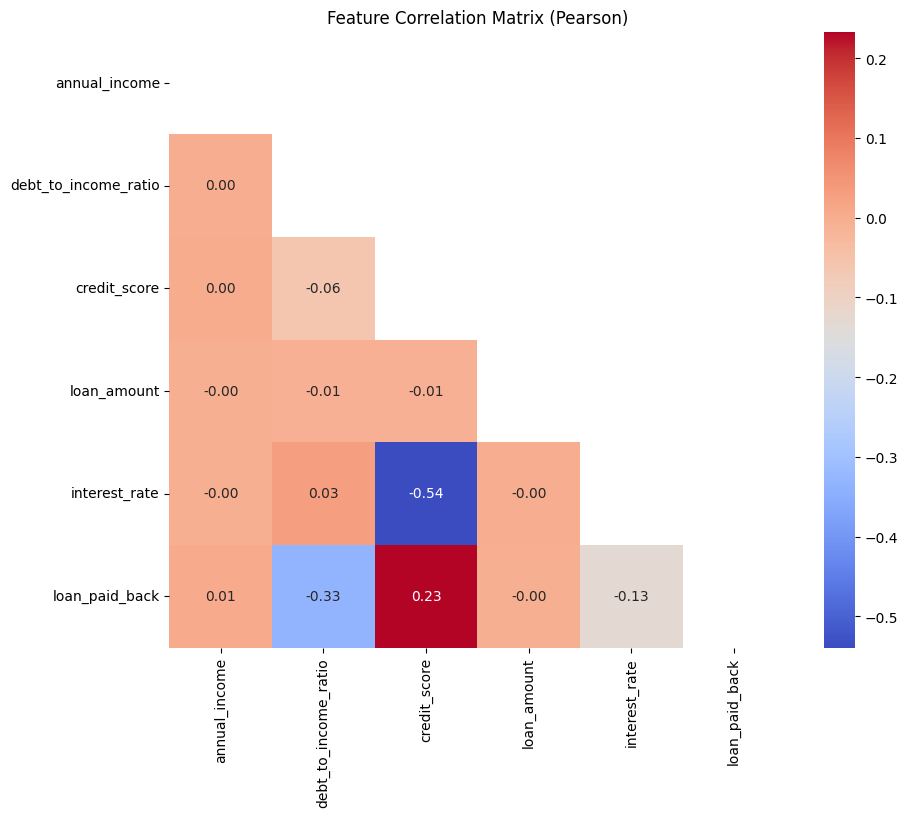

In [7]:
plot_correlation_heatmap(train_df)

## 6. Key Findings & Next Steps

Based on the visual analysis of the training data, we have established the following strategy:

1.  **Class Imbalance:**  
    * **Observation:** The target variable `loan_paid_back` is highly imbalanced.
    * **Action:** We will use **Stratified Splitting** for validation. For tree-based models, we may use `class_weight='balanced'` or `scale_pos_weight` to penalize misclassifying the minority class.

2.  **Numerical Features (Skewness & Outliers):**
    * **Observation:** `annual_income` is extremely right-skewed with significant outliers visible in the boxplots. `debt_to_income_ratio` also exhibits extreme values.
    * **Action:** We will apply **Standard Scaling** (Z-score) to normalize ranges.
        * For `annual_income`, we will rely on the robustness of **Ordinal Encoding** (for grades) and **Tree-based models** to handle non-linearities, rather than aggressively removing outliers which might contain signal.

3.  **Categorical High Cardinality:**
    * **Observation:** `grade_subgrade` has high cardinality (35 distinct values).
    * **Action:** We will implement **Concept Hierarchy**: Extract the high-level `grade` (A, B, C...) from `grade_subgrade` and use **Ordinal Encoding** to capture the risk hierarchy ($A < B < G$), then drop the redundant `grade_subgrade` column to avoid multicollinearity.

4.  **Feature Redundancy:**
    * **Observation:** The correlation matrix shows low pairwise correlation between most numerical features.
    * **Action:** No additional feature dropping is required for numerical columns. We will focus on encoding categorical variables correctly.